문제 : 온도, 습도, 조도, CO2 농도에 따른 객실의 사용유무 판별

y(Occupancy) : 0(비어있음), 1(사용중)

(1) EDA수행 후 의미있는 탐색

In [36]:
import pandas as pd
import numpy as np
data=pd.read_csv("problem1.csv")

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17910 entries, 0 to 17909
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           17910 non-null  object 
 1   Temperature    17910 non-null  float64
 2   Humidity       17910 non-null  float64
 3   Light          17910 non-null  float64
 4   CO2            17889 non-null  float64
 5   HumidityRatio  17910 non-null  float64
 6   Occupancy      17910 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 979.6+ KB


In [38]:
data.isna().sum()

date              0
Temperature       0
Humidity          0
Light             0
CO2              21
HumidityRatio     0
Occupancy         0
dtype: int64

<AxesSubplot:>

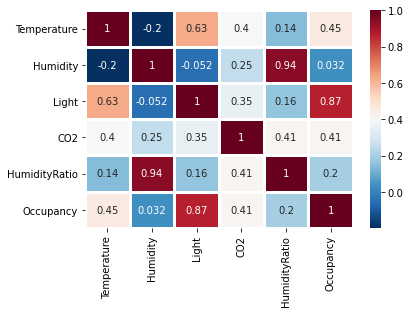

In [39]:
import seaborn as sns
data_corr=data.corr(method='pearson')
sns.heatmap(data_corr, xticklabels=data_corr.columns, yticklabels=data_corr.columns, cmap='RdBu_r', annot=True, linewidth=3)

HumidityRatio와 Humidity 컬럼이 높은 상관관계를 보인다.

In [40]:
data[data.CO2.isnull()].date.values

array(['2015-02-03 19:09:59', '2015-02-03 19:31:00',
       '2015-02-04 18:08:00', '2015-02-05 06:08:00',
       '2015-02-05 16:09:59', '2015-02-08 08:06:00',
       '2015-02-08 11:54:00', '2015-02-08 20:58:59',
       '2015-02-09 06:04:59', '2015-02-09 07:31:00',
       '2015-02-09 07:49:00', '2015-02-10 07:53:59',
       '2015-02-12 00:34:00', '2015-02-12 10:53:00',
       '2015-02-12 15:04:00', '2015-02-12 20:38:00',
       '2015-02-13 22:53:59', '2015-02-15 16:41:59',
       '2015-02-16 00:53:59', '2015-02-17 01:56:00',
       '2015-02-18 06:20:00'], dtype=object)

결측치가 연속적인 값이 아닌 것을 확인

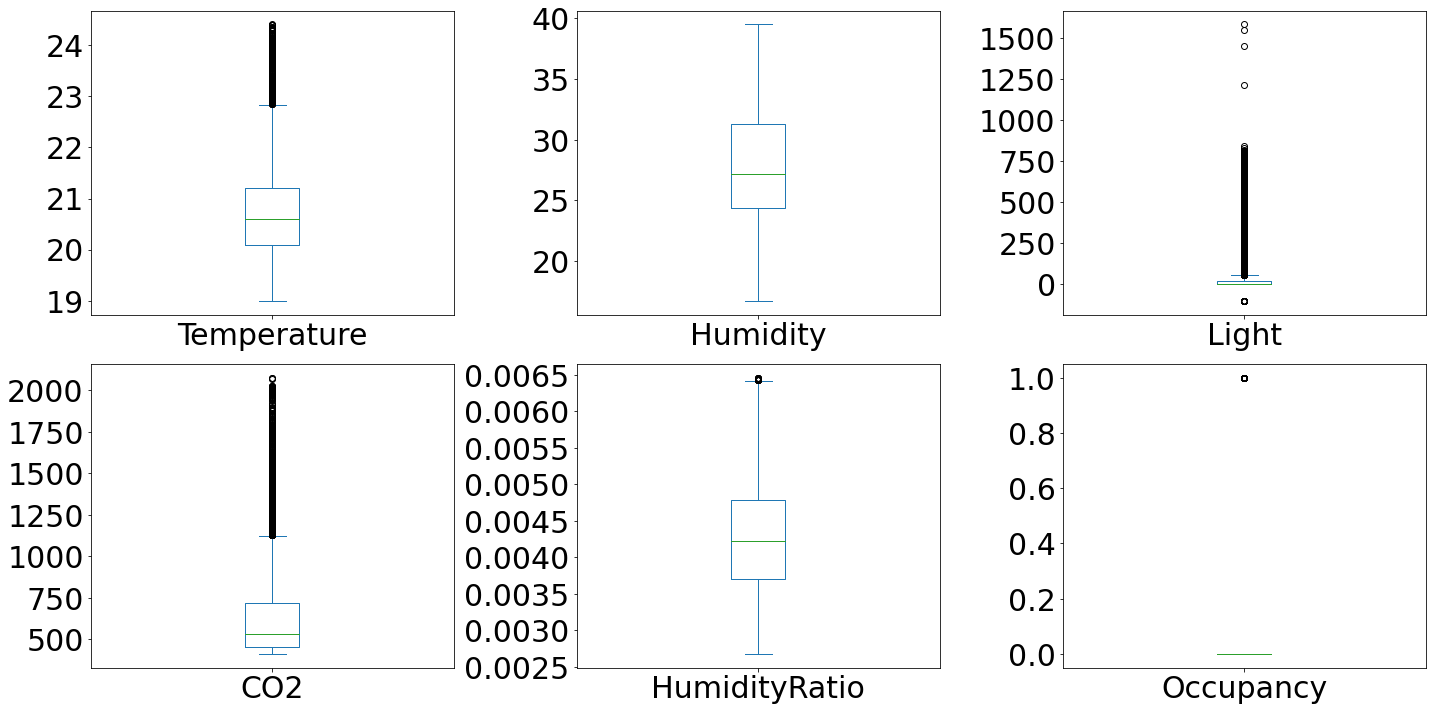

In [41]:
import matplotlib.pyplot as plt
data.plot(kind='box', subplots=True, layout=(2,3), figsize=(20,10), fontsize=30)
plt.tight_layout()
plt.show()

Humidity와 HumidityRatio를 제외한 데이터의 경우 이상치가 상대적으로 많이 존재한다.

In [42]:
display(data[data.Light<0].shape)
display(data.describe())
#data[data.Light<0]
#-99로 존재

(50, 7)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,17910.000000,17910.000000,17910.000000,17889.000000,17910.000000,17910.000000
mean,20.749036,27.589163,78.157369,647.700865,0.004175,0.117253
std,0.994012,5.043595,168.574068,285.997340,0.000755,0.321730
min,19.000000,16.745000,-99.000000,412.750000,0.002674,0.000000
25%,20.100000,24.390000,0.000000,453.000000,0.003702,0.000000
50%,20.600000,27.200000,0.000000,532.666667,0.004222,0.000000
75%,21.200000,31.290000,22.000000,722.000000,0.004790,0.000000
max,24.408333,39.500000,1581.000000,2076.500000,0.006461,1.000000


↑ Light의 경우 -99가 50개 존재

In [43]:
#datetime으로 데이터타입 변경
data['date']=pd.to_datetime(data['date'])
data['date']

0       2015-02-02 14:19:59
1       2015-02-02 14:22:00
2       2015-02-02 14:23:00
3       2015-02-02 14:23:59
4       2015-02-02 14:25:59
                ...        
17905   2015-02-18 09:08:59
17906   2015-02-18 09:10:00
17907   2015-02-18 09:15:00
17908   2015-02-18 09:16:00
17909   2015-02-18 09:19:00
Name: date, Length: 17910, dtype: datetime64[ns]

In [44]:
timedeltas=data['date'].diff().dt.seconds.dropna()
display(timedeltas.describe())

count    17909.000000
mean        71.357474
std        241.363584
min         59.000000
25%         60.000000
50%         60.000000
75%         61.000000
max      25680.000000
Name: date, dtype: float64

date컬럼의 결측치를 제외하고 초단위 차분을 해봤을 때, 결측치 값 사이의 75%는 61초 차이, 최대 시간차이는 25680초로 7시간 차이가 존재한다. 시계열 데이터로 데이터를 해석할 경우 이 사이의 시간들은 결측치로 볼 수 있다.

(2) 결측치 대체

CO2 컬럼에 nan값으로 비어있는 데이터는 직전, 직후 데이터를 비교해서 Occupancy값이 변화하지 않거나, date값이 3분이내로 연속하는 데이터라고 한다면 직전 CO2값으로 대체 한다. 위의 두 기준에 해당한다면 모든 CO2의 결측치를 대체 할 수 있고 데이터의 품질을 손상 시키지 않다고 판단 할 수 있다

In [45]:
for value in data[data.CO2.isnull()].index:
    target=data.iloc[value-1:value+1]
    difftime=target['date'].diff().dt.seconds.dropna()
    if target.Occupancy.nunique()==1 and len(difftime[difftime>180])==0:
    #unique의 개수
        data.loc[value, 'CO2']=data.loc[value-1].CO2

In [46]:
data.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

(3) 추가적으로 데이터의 질 및 품질관리를 향상시킬만한 내용 작성

In [47]:
data.loc[data.Light==-99, 'Light'] =0
data.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,17910.000000,17910.000000,17910.000000,17910.000000,17910.000000,17910.000000
mean,20.749036,27.589163,78.433750,647.715796,0.004175,0.117253
std,0.994012,5.043595,168.364401,285.980241,0.000755,0.321730
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.100000,24.390000,0.000000,453.000000,0.003702,0.000000
50%,20.600000,27.200000,0.000000,532.733333,0.004222,0.000000
75%,21.200000,31.290000,22.000000,722.000000,0.004790,0.000000
max,24.408333,39.500000,1581.000000,2076.500000,0.006461,1.000000


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17910 entries, 0 to 17909
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           17910 non-null  datetime64[ns]
 1   Temperature    17910 non-null  float64       
 2   Humidity       17910 non-null  float64       
 3   Light          17910 non-null  float64       
 4   CO2            17910 non-null  float64       
 5   HumidityRatio  17910 non-null  float64       
 6   Occupancy      17910 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 979.6 KB


(4) 데이터 불균형이 있는지 확인

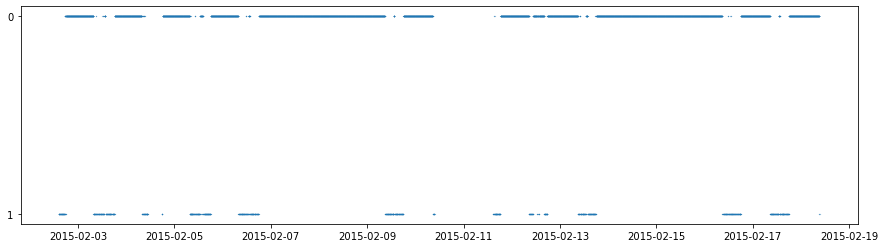

0    15810
1     2100
Name: Occupancy, dtype: int64

In [49]:
plt.figure(figsize=(15,4))
#날짜와, 0/1(비어있음/사용중) 시각화
plt.scatter(data['date'], data['Occupancy'].astype('str'), s=0.03 )
plt.show()
data.Occupancy.value_counts()

비어있는 날이 15,810 차있는날이 2100으로 불균형이 존재한다.

- 오버샘플링

In [50]:
from sklearn.model_selection import train_test_split

X=data.drop(columns=['Occupancy'])
y=data['Occupancy']

X_train, X_test, y_train, y_test=train_test_split(X, y, stratify=y, random_state=43, test_size=0.35)

In [26]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
X_train['date'].view('int') // 10**9
#X_train.loc[:,'datetime'] = X_train['date'].view('int') // 10**9
#X_test.loc[:,'datetime'] = X_test['date'].view('int') // 10**9

ValueError: Length of values (23282) does not match length of index (11641)

In [51]:
#X_train['date'].view('int')
X_train['new']=X_train['date'].astype(str)

In [ ]:
X_train['new'].view('int')//10**9

In [ ]:
X_test.loc[:, 'datetime']=X_test['date'].view('int')//10**9

X_train

In [ ]:
X_train

In [25]:
X_test.isna().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
dtype: int64

In [52]:
df=data
from sklearn.model_selection import train_test_split

# train,test 데이터를 분리하고 train 데이터에 대해서만 오버 샘플링을 진행한다 
X  =df.drop(columns=['Occupancy'])
y  =df['Occupancy']

X_train , X_test , y_train, y_test  = train_test_split(X,y,stratify=y,random_state=43,test_size=0.35)


from imblearn.over_sampling import RandomOverSampler,SMOTE

#datetime 형태로는 샘플링 할수 없기에 timestamps 형식으로 바꿔서 샘플링을 진행한다
X_train.loc[:,'datetime'] = X_train['date'].view('int') // 10**9
X_test.loc[:,'datetime'] = X_test['date'].view('int') // 10**9


from sklearn.preprocessing import StandardScaler


X_imb  = X_train.drop(columns = ['date']).reset_index(drop=True).copy()
y_imb  = y_train.reset_index(drop=True).copy()

X_samp, y_samp = RandomOverSampler(random_state=2022).fit_resample(X_imb,y_imb)
total = pd.concat([X_samp,y_samp],axis=1)
total['date'] = pd.to_datetime(total['datetime'], unit='s')


SMOTE_X_samp, SMOTE_y_samp = SMOTE(random_state=2022).fit_resample(X_imb,y_imb)
SMOTE_total = pd.concat([SMOTE_X_samp,SMOTE_y_samp],axis=1)
SMOTE_total['date'] = pd.to_datetime(SMOTE_total['datetime'], unit='s')


plt.figure(figsize=(15,4))
plt.title('RandomSampling')
plt.scatter(total['date'],total['Occupancy'].astype('str'),s=0.03)
plt.show()



plt.figure(figsize=(15,4))
plt.title('SMOTE')
plt.scatter(SMOTE_total['date'],SMOTE_total['Occupancy'].astype('str'),s=0.03)
plt.show()

print('''
RandomSampling 대비 SMOTE에서 좀 더 다양한 차원의 샘플이 생성됨을 볼수 있다. (02-18일 부근)
''')

ValueError: Length of values (23282) does not match length of index (11641)